In [1]:
import pandas as pd
from typing import Tuple, List
import numpy as np
import os
from ruptures_simple.cost import CostL2
from ruptures_simple.search import BinSeg
from ruptures_simple.search import SegNode
from plot_utils import plot_seg_tree
from tree_utils import child_sort
import graphviz
import matplotlib.pyplot as plt
import matplotlib
from collections import deque
font = {'size': 24}

matplotlib.rc('font', **font)

In [2]:
TREE_IMG_ROOT = "binseg_tree_example"
CPD_IMG_ROOT = "binseg_cpd_example"

In [3]:
def get_data_file_list(dataset_path: str) -> List[str]:
    return os.listdir(dataset_path)

In [4]:
def read_dataset(csv_path: str, index_field: str, data_field: str) -> Tuple[np.ndarray, np.ndarray]:
    df = pd.read_csv(csv_path)
    return df[index_field].to_numpy(), df[data_field].to_numpy()

In [5]:
def save_tree_to_file(workload_name: str, graph: graphviz.Digraph):
    if not os.path.exists(TREE_IMG_ROOT):
        os.makedirs(TREE_IMG_ROOT)
    graph.attr(rankdir='TB')  # Set direction to top to bottom
    graph.render(os.path.join(TREE_IMG_ROOT, workload_name), format="pdf", cleanup=True)

In [6]:
def get_candidate_cpds(root: SegNode, np_data: np.ndarray, epsilon: float):
    """
    Use BFS to look for parent nodes satisfying requirement and ignore the child
    """
    node_deque = deque([])
    node_deque.append(root)
    seg_list = []
    while len(node_deque) > 0:
        current_node: SegNode = node_deque.popleft()
        if current_node is None:
            continue
        else:
            if current_node.cost < (current_node.end-current_node.start)*epsilon: # satisfied
                seg_list.append((current_node.start, current_node.end))
            else:
                if current_node.left_child is None and current_node.right_child is None:
                    seg_list.append((current_node.start, current_node.end))
                else:
                    node_deque.append(current_node.left_child)
                    node_deque.append(current_node.right_child)
    seg_list = sorted(seg_list, key=lambda x: x[0])
    cpd_list = [seg[0] for seg in seg_list[1:]]
    return cpd_list

In [7]:
def plot_cpd_result(candidate_cpds: List, np_data: np.ndarray, workload_name: str):
    color_workload, color_change = "#3F51B5", "#FF5722"  # material teal
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 5)
    ax.plot(np.arange(len(np_data)), np_data, color=color_workload)
    ax.scatter(np.arange(len(np_data)), np_data, color=color_workload)
    for cp in candidate_cpds:
        ax.axvline(x=cp, color=color_change, linestyle='--', linewidth=1)
    ax.set_xlabel("t")
    ax.set_ylabel("x")
    ax.set_title(workload_name.replace("_", " "))
    ax.grid(True, linestyle="--")
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if not os.path.exists(CPD_IMG_ROOT):
        os.makedirs(CPD_IMG_ROOT)
    fig.savefig(CPD_IMG_ROOT+"/"+workload_name+".pdf")
    return fig, ax

(<Figure size 1500x500 with 1 Axes>,
 <Axes: title={'center': 'binary segmentation example'}, xlabel='t', ylabel='x'>)

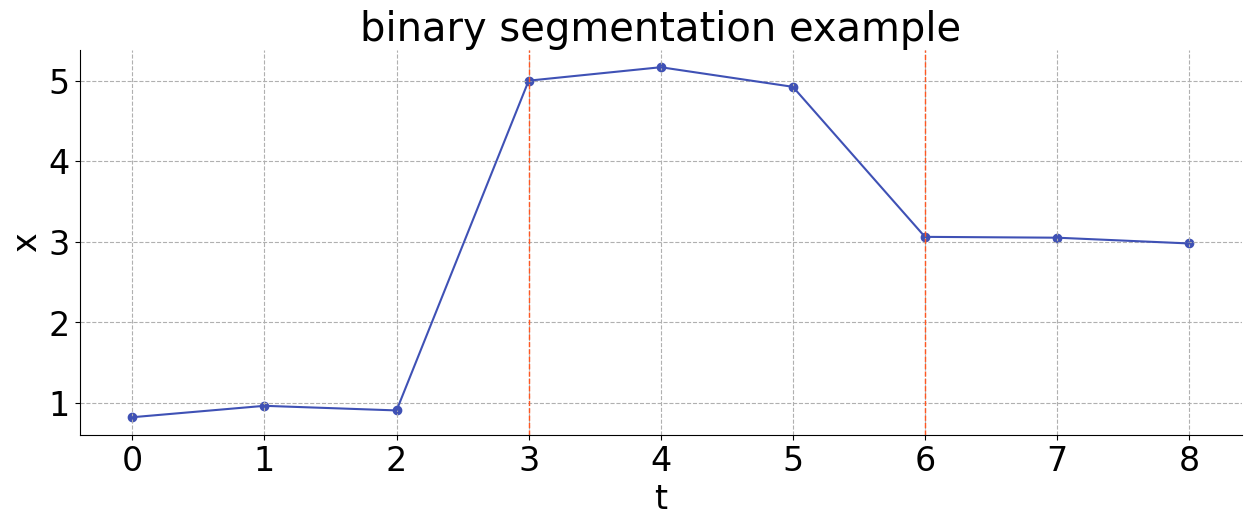

In [8]:
np_data = np.concatenate([np.random.normal(1, 0.1, 3), np.random.normal(5, 0.1, 3), np.random.normal(3, 0.1, 3)])
algo = BinSeg(cost_model=CostL2(), init_seg_size=1)
algo.fit(np_data)
root_seg = algo.bin_search()
child_sort(root_seg)
graph = plot_seg_tree(root_seg)
save_tree_to_file("example", graph)
candidate_cpds = get_candidate_cpds(root_seg, np_data, 0.5)
plot_cpd_result(candidate_cpds, np_data, "binary_segmentation_example")